# JEM092 Asset Pricing - Homework 1

### Group 82780095

Petr Dvořáček, Jan Kubal, Matyáš Mattanelli

---

Throughout the assignment we use the libraries loaded in the cell below. Some of them may need to be installed before running our code.

In [4]:
#Loading the necessary libraries
suppressPackageStartupMessages({
    library(quantmod) #getSymbols function
    library(rvest) #Web scraping
    library(stringr) #Regular expressions
    library(xts) #Managing xts objects
    library(V8) #Evaluating html variables
    library(PortfolioAnalytics) #GMVP and efficient frontier
    library(ROI.plugin.glpk) #Portfolio optimization
    library(ROI.plugin.quadprog) #Portfolio optimization
})

Warning message:
"package 'rvest' was built under R version 4.1.3"
Warning message:
"package 'V8' was built under R version 4.1.3"
Warning message:
"package 'PortfolioAnalytics' was built under R version 4.1.3"
Warning message:
"package 'PerformanceAnalytics' was built under R version 4.1.3"


## Task 1

In the first task we download the required data. We start by loading the csv file with the assigned tickers.

In [5]:
#Loading the assigned csv file
tickers_to_download <- read.csv("data_HW1/82780095_data_download.csv")
no_of_tickers <- nrow(tickers_to_download) #Storing the number of tickers for future use

#### Adjusted Close Price and Volume

We get the adjusted close price and volume daily data from Yahoo Finance using the ``getSymbols()`` function from the ``quantmod`` package.

In [6]:
#Downloading the data from Yahoo Finance (runtime 3m 15s)
yahoo_data_list <- vector("list", no_of_tickers) #Initializing an empty list for the data
options("getSymbols.warning4.0"=FALSE) #Command to prevent an annoying message from appearing
for (i in 1:no_of_tickers) { #Looping through the tickers
    yahoo_data_list[[i]] <- getSymbols(tickers_to_download[i, 2], src="yahoo", auto.assign = F, from = "2007-01-01", to = "2022-03-01")
}

We stored the data for each ticker as an element of a list. Now we check that for each ticker we have volume in the 5th column and adjusted close price in the 6th column.

In [7]:
#Checking that we have adjusted close price and volume in appropriate columns for each ticker
check_col_name <- function(ticker_data, pattern, column_no) { #Defining a function to check if a column name matches a pattern
    ifelse(strsplit(names(ticker_data)[column_no], "\\.")[[1]][2] == pattern, return(T), return(F)) 
}
#Applying the function on all tickers for both Volume and Adjusted price
print(paste("Volume in the 5th column: ", sum(unlist(lapply(yahoo_data_list, check_col_name, pattern = "Volume", column_no = 5))), sep = ""), quote = F)
print(paste("Adjusted Close Price in the 6th column: ", sum(unlist(lapply(yahoo_data_list, check_col_name, pattern = "Adjusted", column_no = 6))), sep = ""), quote = F)

[1] Volume in the 5th column: 250
[1] Adjusted Close Price in the 6th column: 250


Since the check was successful, we can now merge the data for all tickers into a single xts object.

In [8]:
#Merging the available data into a single xts object
merged_yahoo_data <- merge.xts(yahoo_data_list[[1]][, 5:6], yahoo_data_list[[2]][, 5:6]) #Initial merge, adjusted close price and volume are in the 5th and 6th columns, respectively
for (iter in 3:no_of_tickers) { #Loop through the rest of the tickers and append each to the merged object
    merged_yahoo_data <- merge.xts(merged_yahoo_data, yahoo_data_list[[iter]][, 5:6])
}

We check that the number of column is 500 (250 tickers and two columns for each ticker).

In [9]:
#Checking that the number of columns is correct
ncol(merged_yahoo_data) == no_of_tickers * 2 #Two columns for each ticker

[1] TRUE

In case we need it, we can also export the result as a csv file for future use.

In [11]:
#Exporting to csv just in case
#write.zoo(merged_yahoo_data, file = "adjusted_and_volume.csv", sep = ",")

#### Book value per share

Getting the Book value per share data is a bit more complex. Firstly, we find the company names with the help of the ``curlGetHeaders`` function. Then, we construct the urls.

In [12]:
#Getting the urls (runtime 1m47s)
urls_bv <- rep(NA, no_of_tickers) #Empty vector for the urls
for (iter in 1:no_of_tickers) { #Loop through all the tickers
    patt <- curlGetHeaders(paste0("https://www.macrotrends.net/stocks/charts/", tickers_to_download[iter, 2]))[5] #Save the response
    name_and_ticker <- str_extract(patt, paste0(tickers_to_download[iter, 2], "/.*/")) #Extract the relevant pattern from the string
    urls_bv[iter] <- paste0("https://www.macrotrends.net/stocks/charts/", name_and_ticker, "price-book") #Complete the url and save it
}

Now that we have the urls, we can scrape the data. For each url we get the html code using the ``html_read`` function. Then we locate the table containing the data of interest. We loop through the rows to acquire the date and book value per share. We store the results as an xts object. Finally, we store the object for each ticker as an element of a list

In [13]:
#Downloading the data (runtime 3m6s)
bv_per_share_data <- vector("list", no_of_tickers) #Empty list to store the data
for (iter in 1:no_of_tickers) { #Loop through all tickers
  html_request <- read_html(urls_bv[iter]) #Sending the request
  trs <- html_request %>% 
    html_element("table") %>% #Finding the table
    html_element("tbody") %>% #FInding the body of the table
    html_elements("tr") #Finding the rows of the table
  dates <- rep(NA, length(trs)) #Empty vector to store the dates
  values <- rep(NA, length(trs)) #Empty vector to store the values
  for (iter2 in 1:length(trs)) { #Looping through all the rows
    tds <- html_elements(trs[iter2], "td") #Extracting the cells within each row
    dates[iter2] <- html_text(tds)[1] #First cell is the date
    values[iter2] <- as.numeric(gsub("\\$","",html_text(tds)[3])) #Third cell is book value per share
  }
  dates <- as.Date(dates) #Convert dates from string to Date format
  xts_object <- xts(x = values, order.by = dates) #Create an xts object from the results
  names(xts_object) <- paste0(tickers_to_download[iter, 2], ".BV_per_share") #Name it
  bv_per_share_data[[iter]] <-  xts_object #Store the results
}

Similarly to the previous case, we simply merge the data into a single xts object. We should keep in mind that the data are quaterly. Since previously we downloaded daily data, we may have to make some adjustments.

In [14]:
#Merging the individual tickers together
merged_bv_per_share_data <- merge.xts(bv_per_share_data[[1]], bv_per_share_data[[2]]) #Initial merge
for (iter in 3:no_of_tickers) {
    if (iter==72) {
        next #Temporarily skipping LUMN
    }
    merged_bv_per_share_data <- merge.xts(merged_bv_per_share_data, bv_per_share_data[[iter]])
}

Again, if nedeed we can export the data as a csv file.

In [15]:
#Exporting to csv just in case
#write.zoo(merged_bv_per_share_data, file = "bv_per_share.csv", sep = ",")

#### Market capitalization

Lastly, we download the market capitalization data. This time we have the direct url for each ticker. We get the html code and extract the script node from the body of the test. A quick inspenction revealed that the text contains a defined variable *chartData* that we can read using JavaScript. We convert the resulting data frame into an xts object and once again store it in a list.

In [16]:
#Downloading the data (runtime 1m34s)
market_cap_data <- vector("list", no_of_tickers)
for (iter in 1:no_of_tickers) { #Looping through all tickers
    html_request <- read_html(paste0("https://www.macrotrends.net/assets/php/market_cap.php?t=", tickers_to_download[iter, 2])) #Sending a request
    script <- html_request %>% #Extracting the relevant element and converting it to text
        html_element("body") %>%
        html_element("script") %>%
        html_text(trim = T)
    ctx <- v8() #The extracted text contains a variable which can be evaluated using JavaScript so we initialize an execution environment
    ctx$eval(str_extract(script,".*]")) #Evaluating the text. The function inside extracts the part that is relevant for us
    extracted_data <- ctx$get("chartData") #Extracting the variable (returns a data frame)
    xts_object <- xts(x = extracted_data[, 2], order.by = as.Date(extracted_data[, 1])) #Saving as an xts object
    names(xts_object) <- paste0(tickers_to_download[iter,2], ".Market_Cap") #Renaming
    market_cap_data[[iter]] <- xts_object #Storing
}

Finally, we merge the acquired data into a single xts object...

In [17]:
#Merging the data
merged_market_cap_data <- merge.xts(market_cap_data[[1]], market_cap_data[[2]]) #Initial merge
for (iter in 3:no_of_tickers) { #Looping through all the tickers
    merged_market_cap_data <- merge.xts(merged_market_cap_data, market_cap_data[[iter]])
}

... and optionally export it.

In [18]:
#Exporting to csv just in case
write.zoo(merged_market_cap_data, file = "market_cap.csv", sep = ",")

#### Merging it all together

In this step we merge all the acquired data together into a one xts object. Since we do not know the nature of the second assignment, we do not process the data any further. In case of need we can use the separate csv files.

In [19]:
#Merging adjusted prices, volume, book value per share, and market capitalization
semifinal_dataset <- merge.xts(merged_yahoo_data, merged_bv_per_share_data, merged_market_cap_data)

In [20]:
#Exporting to csv
#write.zoo(semifinal_dataset, file = "semifinal_dataset.csv", sep = ",")

## Task 2

In this task we form two porftolios and their corresponding efficient frontiers. We start by loading the ticker names that we are supposed to utilize.

In [21]:
#Loading the 20 tickers
tickers_20 <- read.csv("data_HW1/82780095_rand_download.csv")

To facilitate the subsetting in our data set, we find the row number for each ticker.

In [22]:
#Finding the row number for each ticker
iters <- rep(NA, 20)
for (i in 1:20) {   
    iters[i] <- tickers_to_download[tickers_to_download[, 2] == tickers_20[i, 2], 1]
}

Next, we extract the relevant tickers from the data we have acquired. Specifically, we need only the adjusted close price. We also restrict the period as required and convert the data from daily to monthly using the ``to.monthly()`` function.

In [23]:
#Getting data for the relevant tickers and adjusting it
task2_data <- vector("list", 20) #Empty list for the data
for (i in 1:20) { #Looping through the tickers
    task2_data[[i]] <- to.monthly(yahoo_data_list[[iters[i]]]["2014-12/"], name = tickers_20[i, 2])[, 6] #Extracting data from 2015 and later and then converting it to monthly. Keeping only the Adjusted price 
}

From the resulting data we calculate returns using the adjusted close price and the following formula: $\frac{P_{i,t}-P_{i,t-1}}{P_{i,t-1}}$

In [24]:
#Converting to returns and merging into a single xts object
task2_data_returns <- vector("list", 20)
for (i in 1:20) {
    task2_data_returns[[i]] <- (task2_data[[i]] - lag(task2_data[[i]]))/lag(task2_data[[i]])
}
#Merging
final_returns <- merge.xts(task2_data_returns[[1]], task2_data_returns[[2]])
for (i in 3:20) {
    final_returns <- merge.xts(final_returns, task2_data_returns[[i]])
}
names(final_returns) <- gsub(".Adjusted", "", names(final_returns)) #Renaming for conciseness
final_returns <- final_returns["2015/"] #We keep only the data from 2015-2022

Since the data is ready, we can calculate the Global Minimum Variance Portoflio for both groups of tickers.

In [25]:
#Calculating the Global Minimum Variance Portfolios
#Portfolio A
pspecA <- portfolio.spec(assets = tickers_20[1:10, 2]) #Specifying the stock names
initial_portfolioA <- add.constraint(portfolio = pspecA, type = "full_investment") #Adding a constraint
minvarA <- add.objective(portfolio = initial_portfolioA, type = "risk", name = "var") #Adding an objective
opt_minvarA <- optimize.portfolio(R = final_returns[, 1:10], portfolio = minvarA, optimize_method = "ROI") #Optimizing
#Portfolio B
pspecB <- portfolio.spec(assets = tickers_20[11:20, 2]) #Specifying the stock names
initial_portfolioB <- add.constraint(portfolio = pspecB, type = "full_investment") #Adding a constraint
minvarB <- add.objective(portfolio = initial_portfolioB, type = "risk", name = "var") #Adding an objective
opt_minvarB <- optimize.portfolio(R = final_returns[, 11:20], portfolio = minvarB, optimize_method = "ROI") #Optimizing

Now we can construct the portfolios for the use in the efficient frontier. We specify a box constraint with minimum as the minimum of the weights from the respective GMVP and maximum equal to 1.

In [26]:
#Constructing portfolios A and B
pspec_fr_A <- portfolio.spec(assets = tickers_20[1:10, 2])
pspec_fr_B <- portfolio.spec(assets = tickers_20[11:20, 2])
portfolio_fr_A <- add.constraint(portfolio = pspec_fr_A, type = "box", min = min(opt_minvarA$weights), max = 1)
portfolio_fr_B <- add.constraint(portfolio = pspec_fr_B, type = "box", min = min(opt_minvarB$weights), max = 1)

In [27]:
#Creating the efficient frontier
eff_front_A <- create.EfficientFrontier(R = final_returns[, 1:10], portfolio = portfolio_fr_A, type = 'mean-var')
eff_front_B <- create.EfficientFrontier(R = final_returns[, 11:20], portfolio = portfolio_fr_B, type = 'mean-var')

Warning message:
"executing %dopar% sequentially: no parallel backend registered"


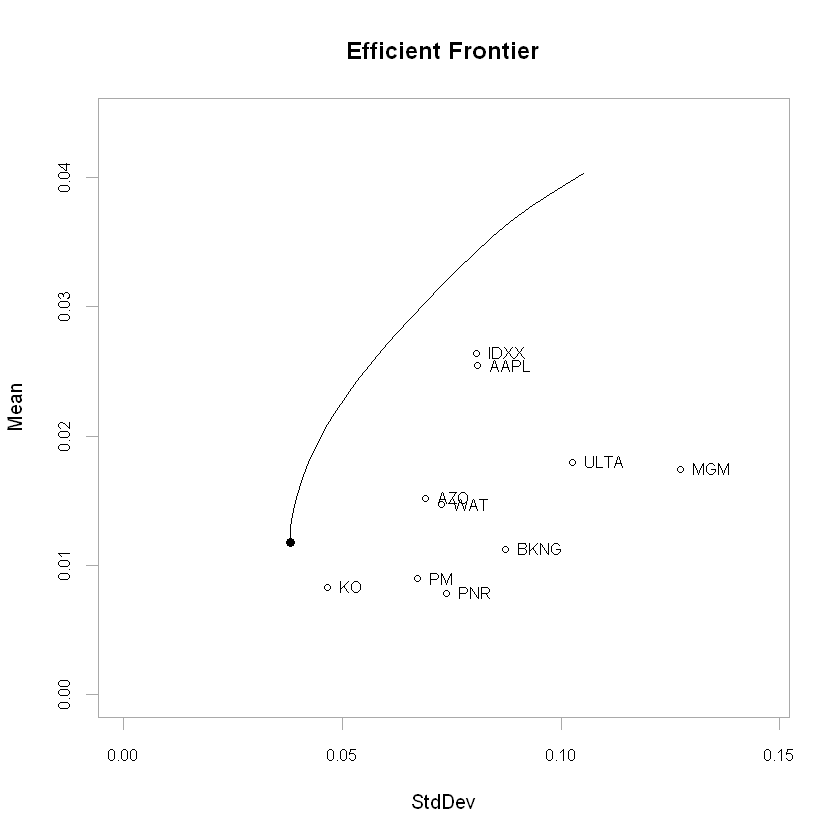

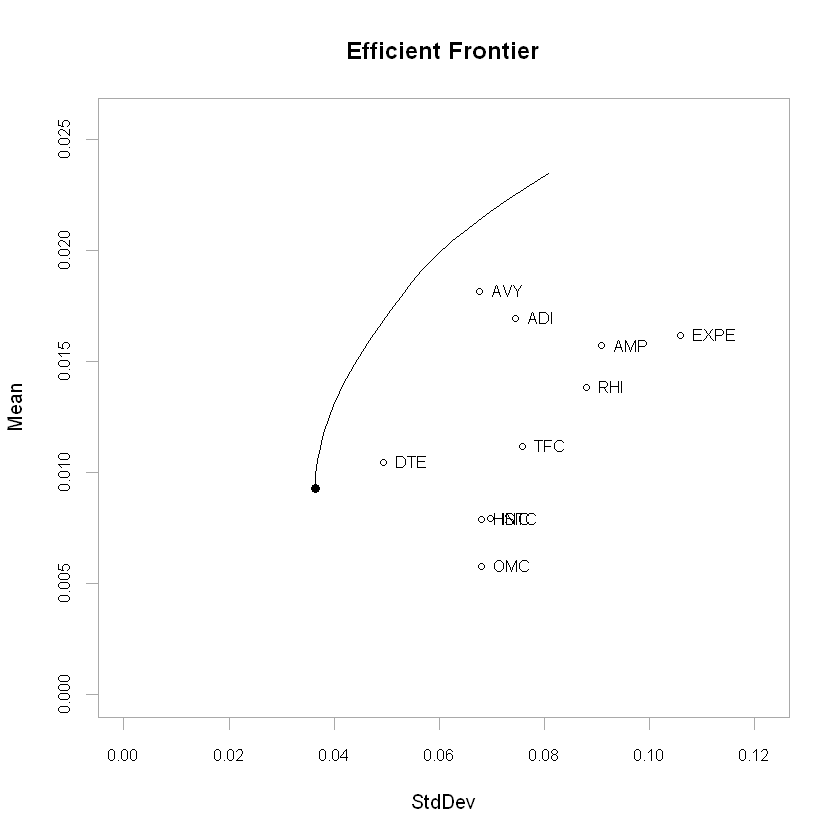

In [28]:
#Plotting the Efficient Frontier
chart.EfficientFrontier(eff_front_A, match.col = 'StdDev', type = 'l', tangent.line = FALSE, rf = NULL)
chart.EfficientFrontier(eff_front_B, match.col = 'StdDev', type = 'l', tangent.line = FALSE, rf = NULL)

In [29]:
AB_comb <- combine.portfolios(list(portfolio_fr_A, portfolio_fr_B))

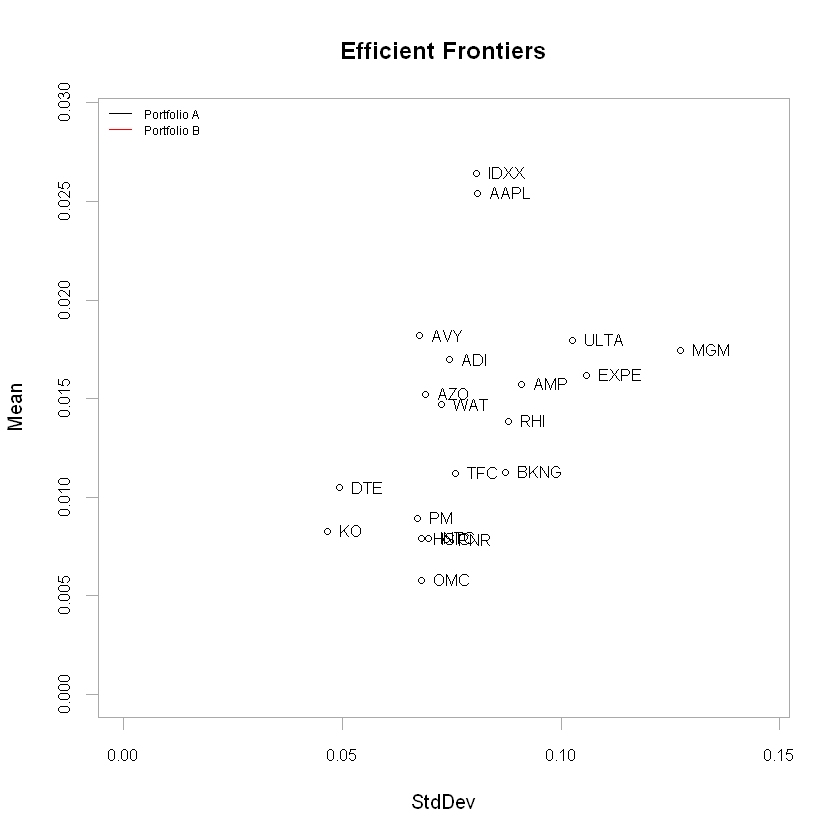

In [30]:
chart.EfficientFrontierOverlay(R = final_returns, portfolio_list = AB_comb, type = 'mean-var',
match.col = 'StdDev', col = c("black", "red"), lty = c(1,1), lwd = c(0.5,0.5), legend.loc="topleft", 
                               legend.labels=c("Portfolio A","Portfolio B"), cex.legend=0.6,)

## Task 3

In [31]:
#getting the data required for task 3

task3_data <- vector("list", 20) #Empty list for the data


for (i in 1:20) { #Looping through the tickers
    ticker_volume <- paste(tickers_20[i,2], ".Volume", sep = "") #Pasting the tickers and variables together
    ticker_adjusted <- paste(tickers_20[i,2], ".Adjusted", sep = "") #so the full dataset can be subsetted
    ticker_bv <- paste(tickers_20[i,2], ".BV_per_share", sep = "")
    ticker_market <- paste(tickers_20[i,2], ".Market_Cap", sep = "")
    
    ticker_xts <- semifinal_dataset[, c(ticker_volume, ticker_adjusted, ticker_bv, ticker_market)]["2014-12/"] #Subsetting the full dataset

    task3_data[[i]] <- to.monthly(ticker_xts[,1], name = names(ticker_xts[,1]), OHLC = FALSE) #Extracting data from 2015 further and then converting it to monthly (averages??)
    task3_data[[i]] <- merge.xts(task3_data[[i]], to.monthly(ticker_xts[,2], name = names(ticker_xts[,2]), OHLC = FALSE))
    task3_data[[i]] <- merge.xts(task3_data[[i]], to.monthly(ticker_xts[,3], name = names(ticker_xts[,3]), OHLC = FALSE))
    task3_data[[i]] <- merge.xts(task3_data[[i]], to.monthly(ticker_xts[,4], name = names(ticker_xts[,4]), OHLC = FALSE))
}

Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):
"missing values removed from data"
Warning message in to.period(x, "months", indexAt = indexAt, name = name, ...):


In [32]:
#I think this is the best we can do :/

task3_data[[4]]

         WAT.Volume WAT.Adjusted WAT.BV_per_share WAT.Market_Cap
Dec 2014     193500       112.72            22.79           9.51
Jan 2015     582200       119.05               NA           9.88
Feb 2015     381800       120.38               NA           9.99
Mar 2015     299500       124.32            22.52          10.32
Apr 2015     684000       125.19               NA          10.34
May 2015     545900       133.62               NA          11.03
Jun 2015     634900       128.38            23.49          10.60
Jul 2015     593600       133.49               NA          10.95
Aug 2015     562700       121.38               NA           9.96
Sep 2015     583600       118.21            24.11           9.70
Oct 2015     467100       127.80               NA          10.52
Nov 2015     725600       132.82               NA          10.94
Dec 2015     318700       134.58            25.27          11.08
Jan 2016     599500       121.21               NA           9.85
Feb 2016     447500      

For computing Price Weighted Index (PWI), we use the formula provided in the assignment, i.e.
$$Index_t=\frac{\sum_{i=1}^N P_{i,t}}{divisor}$$
where $P_{i,t}$ stands for price of stock $i$ in period $t$, and $divisor$ is equal to the number of stocks (individual firms) in the sample/portfolio.


In [80]:
PWI_2 <- xts(rep(0, nrow(task3_data[[1]])), order.by=index(task3_data[[1]]))

for (i in 1:nrow(task3_data[[1]])) {
   prices <- c(rep(0, 20))
   for (n in 1:20) {
      prices[n] <- task3_data[[n]][i, 2]
   }
   PWI[i, 1] <- sum(prices) / 20
}

In [81]:
PWI

             [,1]
Dec 2014 140.5572
Jan 2015 132.7355
Feb 2015 148.8306
Mar 2015 147.2843
Apr 2015 149.6104
May 2015 148.5718
Jun 2015 146.1796
Jul 2015 154.5658
Aug 2015 152.1396
Sep 2015 151.9615
Oct 2015 170.2646
Nov 2015 159.4417
Dec 2015 158.7468
Jan 2016 145.8255
Feb 2016 155.7712
Mar 2016 163.5459
Apr 2016 165.3799
May 2016 163.9875
Jun 2016 165.1689
Jul 2016 174.7021
Aug 2016 174.3092
Sep 2016 178.5403
Oct 2016 175.3567
Nov 2016 182.0895
Dec 2016 180.2506
Jan 2017 185.0735
Feb 2017 197.4434
Mar 2017 201.4326
Apr 2017 204.5009
May 2017 205.1754
Jun 2017 202.2957
Jul 2017 207.9509
Aug 2017 196.5187
Sep 2017 199.4832
Oct 2017 203.6137
Nov 2017 201.2960
Dec 2017 202.5898
Jan 2018 218.4375
Feb 2018 215.2026
Mar 2018 216.0411
Apr 2018 220.9787
May 2018 220.1747
Jun 2018 216.9871
Jul 2018 223.6253
Aug 2018 223.2254
Sep 2018 226.4473
Oct 2018 213.8558
Nov 2018 220.9702
Dec 2018 204.7203
Jan 2019 221.1928
Feb 2019 222.4819
Mar 2019 232.0392
Apr 2019 238.5272
May 2019 223.7379
Jun 2019 2